<a href="https://colab.research.google.com/github/pr-shukla/Pursuit-Evasion/blob/main/pursuit_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing required Libraries**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math

# Defining Paramters for Engagement of Pursuer and Evader 

In [4]:
#Dimension of State Space
dim_state = 3

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.4

#Number of Episodes
num_episodes = 50

#Number of Steps
num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 0.3

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

# Defining Function to add random noise in actions to increase Exploration

In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# Defining class **Buffer** to sample minibatch randomly and to update actors and critic parameters

In [6]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

# Creating Actor and Critic Model

In [7]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# Defining Function to Execute Actor Modelto generate actions

In [8]:
def policy(state, noise_object):
    
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]

# Defining Hyperparameters

In [9]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(10000, 64)

# Defining Functions for dynamics of Pursuit EVader Engagement

In [11]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(state):
    L = np.sqrt((state[4] - state[0])**2 + (state[5]-state[1])**2)
    return L

#Magnitude of Velocity Calculator
def V(state):
    v = np.sqrt(state[2]**2+state[3]**2)
    return v

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
    r1 = 10*np.exp(-3*state[0])
    r2 = 10*np.exp(-1*state[1])
    r3 = 5*np.arctan(state[2])
    r =  r1 + r2  + r3 
    return r

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(state):
    x_pursuer = state[0]
    y_pursuer = state[1]
    x_evader = state[4]
    y_evader = state[5]
    
    x_velocity_pursuer = state[2]
    y_velocity_pursuer = state[3]
    
    x_evader_pursuer = x_evader - x_pursuer
    y_evader_pursuer = y_evader - y_pursuer
    
    d = L(state)
    
    angle = math.acos(round((x_evader_pursuer*x_velocity_pursuer+ y_evader_pursuer*y_velocity_pursuer)/d, 4))
    
    return angle

# Transition from Current State to New State
def transition(pursuer_state, state, u):
    
    #angle between velocity and reference axis
    theta_velocity_p = thetap(state) 
    
    old_phi = phi(state)

    #Change in x and y position of Pursuer
    del_xp = state[2]*dt
    del_yp = state[3]*dt

    del_xe = ve*np.cos(te)*dt
    del_ye = ve*np.sin(te)*dt
    
    #Change in Angle between velocity and reference axis
    del_theta_velocity_p = (v/rho)*u*dt
    theta_velocity_p = theta_velocity_p + del_theta_velocity_p
    
    #New x and y position of Pursuer
    state[0] = state[0] + del_xp
    state[1] = state[1] + del_yp

    state[4] = state[4] + del_xe
    state[5] = state[5] + del_ye
    
    #New x and y velocity of Pursuer
    state[2] = 1.0*np.cos(theta_velocity_p)
    state[3] = 1.0*np.sin(theta_velocity_p)
    
    new_phi = phi(state)

    p_state = [0,0,0]
    
    #New phi and phi(dot)
    p_state[1] = phi(state)/np.pi
    p_state[0] = L(state)/30.0
    p_state[2] = (new_phi-old_phi)/(dt)
    
    return p_state, state

# Generating Episodes to train model
**Episodes during training may not appear very nice. But once the model get trained and when we excute that model in next cell you will see the better results**

Episode * 0 * Avg Reward is ==> 3009.478177780129


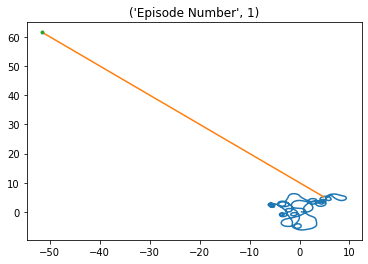

Episode * 1 * Avg Reward is ==> 3014.518320656539


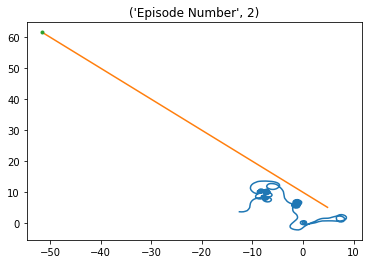

Episode * 2 * Avg Reward is ==> 2959.1456602028206


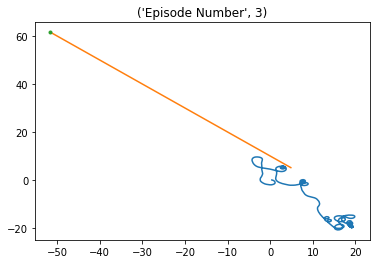

Episode * 3 * Avg Reward is ==> 2982.1895524796546


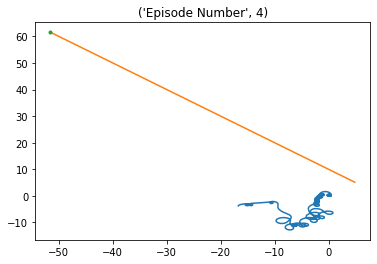

Episode * 4 * Avg Reward is ==> 3301.742139372874


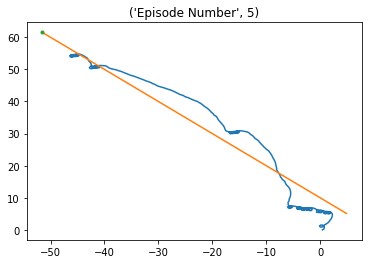

Episode * 5 * Avg Reward is ==> 3373.6449300133827


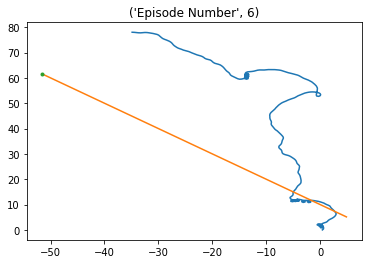

Episode * 6 * Avg Reward is ==> 3692.628998397185


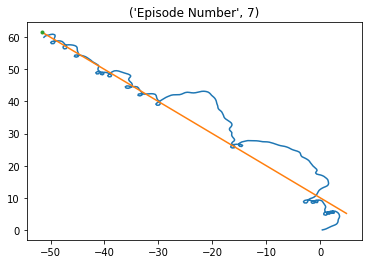

Episode * 7 * Avg Reward is ==> 3882.283728507391


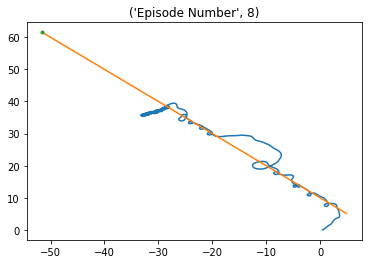

Episode * 8 * Avg Reward is ==> 3988.9453751119386


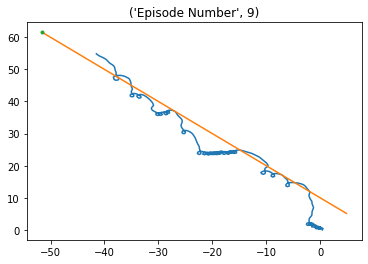

Episode * 9 * Avg Reward is ==> 4145.801346288585


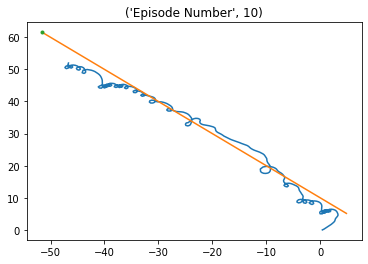

Episode * 10 * Avg Reward is ==> 4168.6539233738895


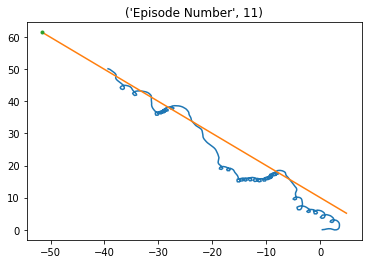

Episode * 11 * Avg Reward is ==> 4289.902904661815


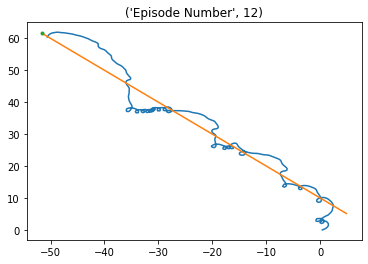

Episode * 12 * Avg Reward is ==> 4278.245450067202


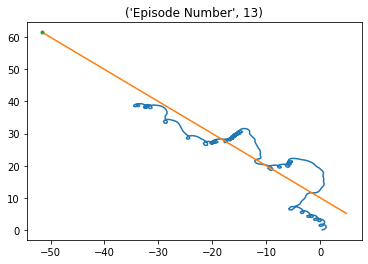

Episode * 13 * Avg Reward is ==> 4360.5374988110525


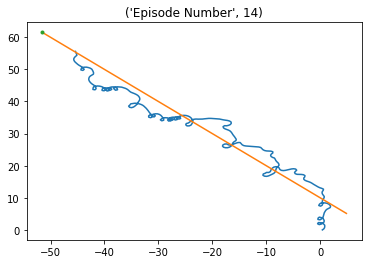

Episode * 14 * Avg Reward is ==> 4336.477601750864


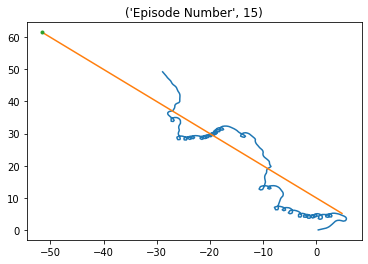

Episode * 15 * Avg Reward is ==> 4418.894023959519


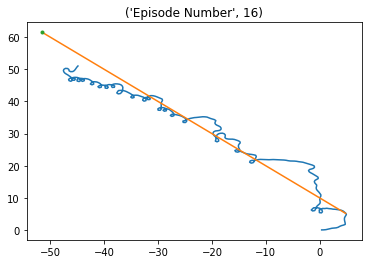

Episode * 16 * Avg Reward is ==> 4398.815859965392


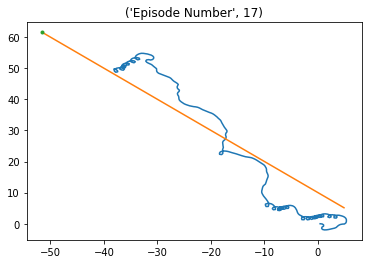

Episode * 17 * Avg Reward is ==> 4404.059814837864


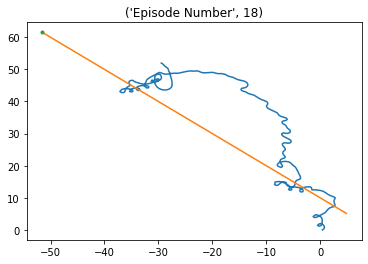

Episode * 18 * Avg Reward is ==> 4425.414915782981


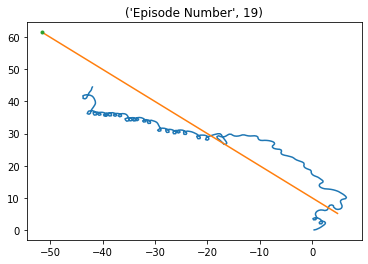

Episode * 19 * Avg Reward is ==> 4473.503660672986


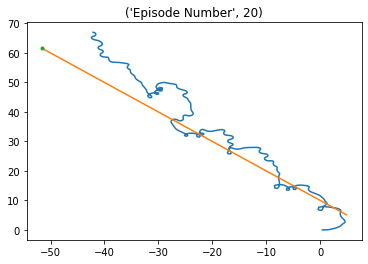

Episode * 20 * Avg Reward is ==> 4462.097285488208


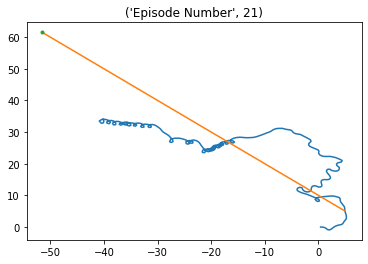

Episode * 21 * Avg Reward is ==> 4459.086123026955


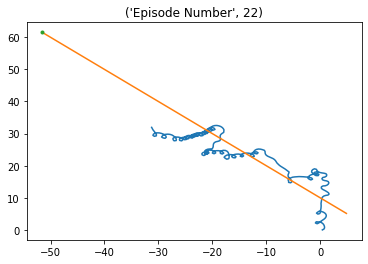

Episode * 22 * Avg Reward is ==> 4475.689527346586


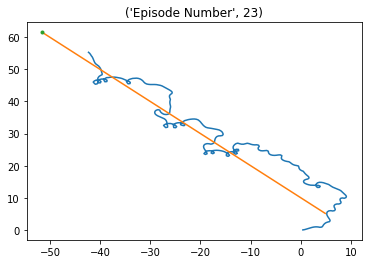

Episode * 23 * Avg Reward is ==> 4446.407512864564


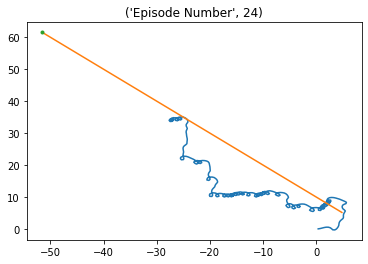

Episode * 24 * Avg Reward is ==> 4434.81694432075


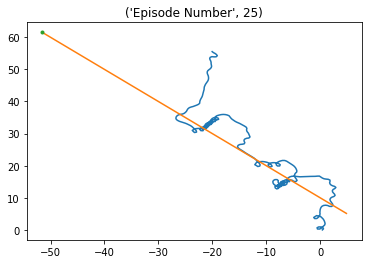

Episode * 25 * Avg Reward is ==> 4415.787230860087


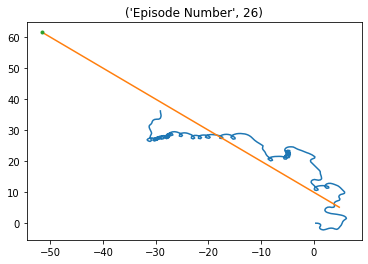

Episode * 26 * Avg Reward is ==> 4403.849502206866


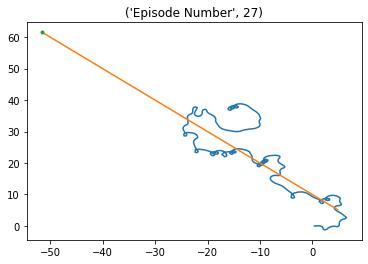

Episode * 27 * Avg Reward is ==> 4396.2833858615695


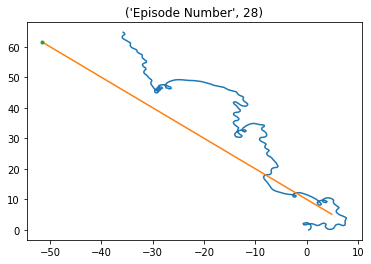

Episode * 28 * Avg Reward is ==> 4398.021020093036


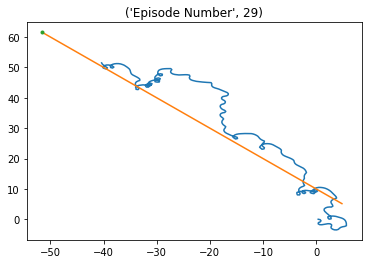

Episode * 29 * Avg Reward is ==> 4358.147078350946


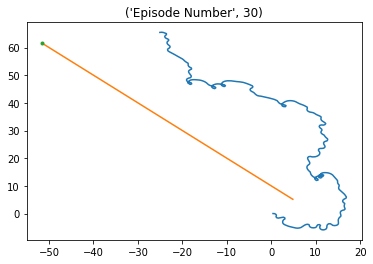

Episode * 30 * Avg Reward is ==> 4374.465842213828


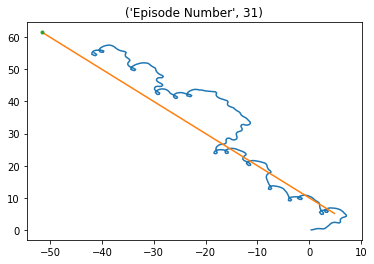

Episode * 31 * Avg Reward is ==> 4371.683090165838


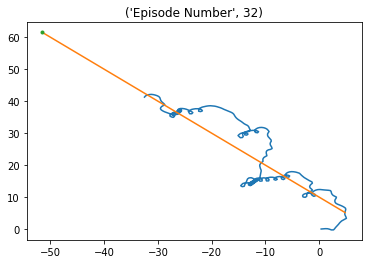

Episode * 32 * Avg Reward is ==> 4386.3493784378625


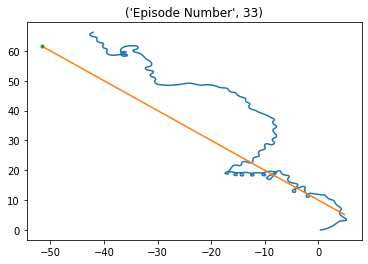

Episode * 33 * Avg Reward is ==> 4370.35021344474


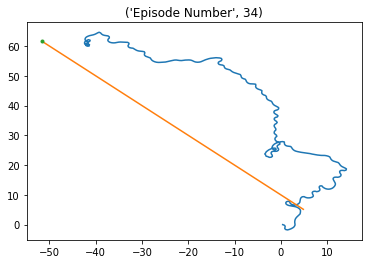

Episode * 34 * Avg Reward is ==> 4363.200437554873


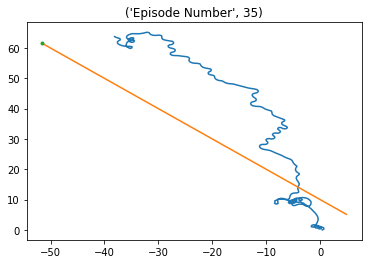

Episode * 35 * Avg Reward is ==> 4331.665297913478


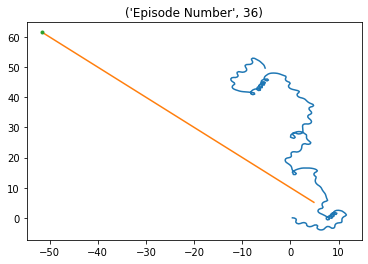

Episode * 36 * Avg Reward is ==> 4314.126543556738


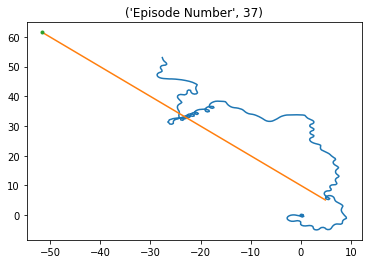

Episode * 37 * Avg Reward is ==> 4294.7217240989185


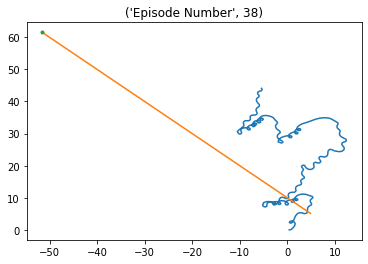

Episode * 38 * Avg Reward is ==> 4296.898794874758


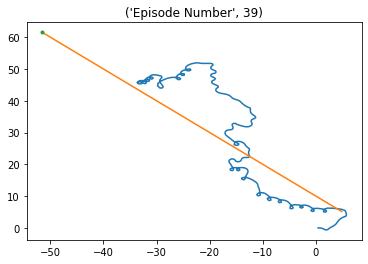

Episode * 39 * Avg Reward is ==> 4315.341056534638


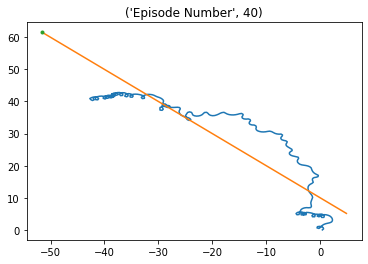

Episode * 40 * Avg Reward is ==> 4332.766692429895


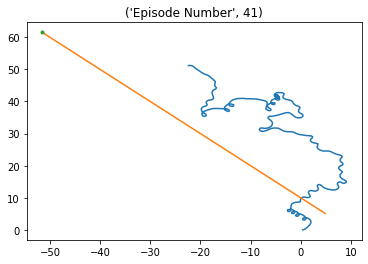

Episode * 41 * Avg Reward is ==> 4349.819253258272


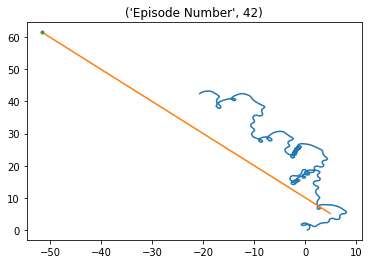

Episode * 42 * Avg Reward is ==> 4391.481528692723


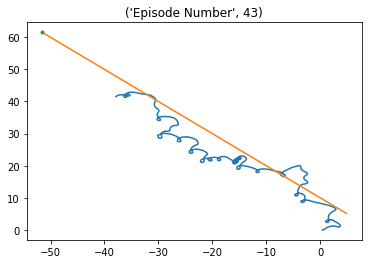

Episode * 43 * Avg Reward is ==> 4403.812401652673


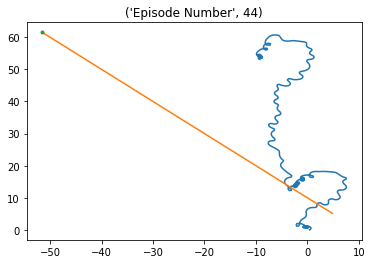

Episode * 44 * Avg Reward is ==> 4381.522866692358


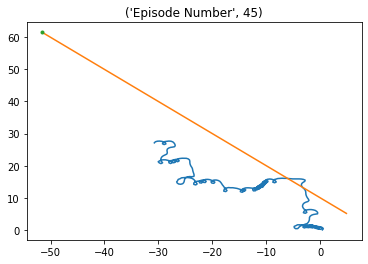

Episode * 45 * Avg Reward is ==> 4387.268923398946


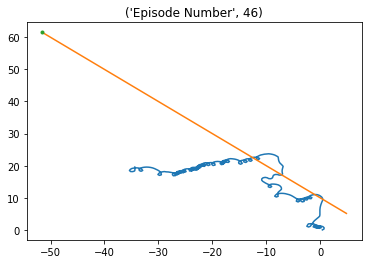

Episode * 46 * Avg Reward is ==> 4353.97002436107


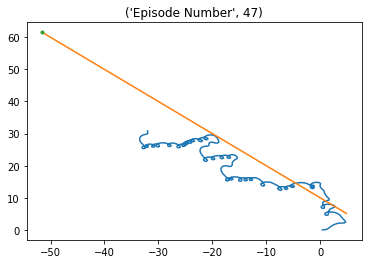

Episode * 47 * Avg Reward is ==> 4344.585329893314


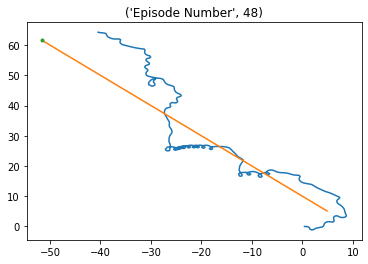

Episode * 48 * Avg Reward is ==> 4320.98370741447


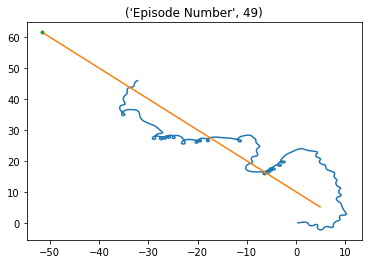

Episode * 49 * Avg Reward is ==> 4275.708154164844


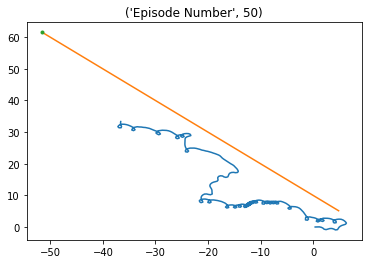

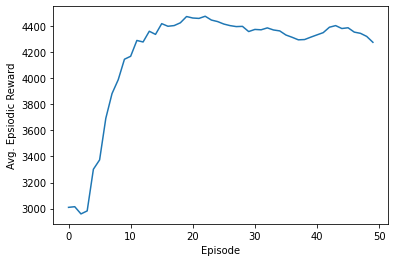

In [12]:
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(num_episodes):

    sys_state = [0.0,0.0,1.0,0.0,5.0, 5.0]
    prev_state = np.array([L(sys_state)/30.0, phi(sys_state)/np.pi,0])
    episodic_reward = 0
    
    xc = []
    yc = []
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)

        # Recieve state and reward from environment.
        new_state, sys_state = transition(prev_state, sys_state, float(action[0]))
        rew = reward(new_state)

        buffer.record((prev_state, action, rew, new_state))
        episodic_reward += rew

        buffer.learn()
        update_target(tau)

        prev_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[4])
        yce.append(sys_state[5])
        
    xc1 = [sys_state[4]]
    yc1 = [sys_state[5]]

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc,yc)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

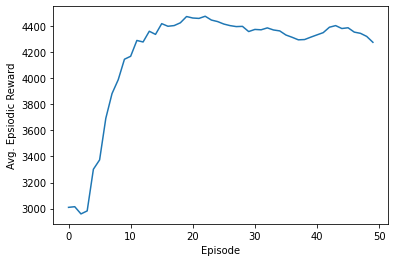

In [13]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

# Executing our trained model here to analyze how good the parameters are.

****TARGET CAPTURED****
Captured after 480 steps
Episode * 0 * Avg Reward is ==> 7440.502349765228


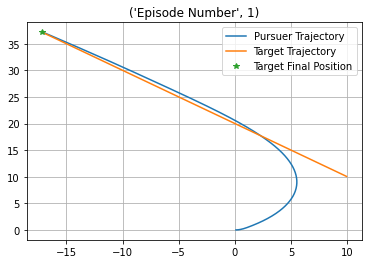

'\n*************************************\nModel Cheker for straight line evader\n*************************************\n'

In [14]:

dt = 0.1

rho = 0.3

ve = 0.8

#angle between initial velocity and reference
te = 3*np.pi/4

def transition_e_sl(pursuer_state, state, u): 
    
    #angle between velocity and reference axis
    theta_velocity_p = thetap(state) 
    
    old_phi = phi(state)

    #Change in x and y position of Pursuer
    del_xp = state[2]*dt
    del_yp = state[3]*dt
    
    #Change in x and y position of Evader
    del_xe = ve*np.cos(te)*dt
    del_ye = ve*np.sin(te)*dt
    
    #Change in Angle between velocity and reference axis
    del_theta_velocity_p = (v/rho)*u*dt
    theta_velocity_p = theta_velocity_p + del_theta_velocity_p

    #New x and y position of Pursuer
    state[0] = state[0] + del_xp
    state[1] = state[1] + del_yp
    
    #New x and y position of Evader
    state[4] = state[4] + del_xe
    state[5] = state[5] + del_ye
    
    #New x and y velocity of Pursuer
    state[2] = 1.0*np.cos(theta_velocity_p)
    state[3] = 1.0*np.sin(theta_velocity_p)
    
    new_phi = phi(state)

    p_state = [0,0,0]
    
    #New phi and phi(dot)
    p_state[1] = phi(state)/np.pi
    p_state[0] = L(state)/30.0
    p_state[2] = (new_phi-old_phi)/dt
    return p_state, state

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy()
    return [sampled_actions]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(1):

    sys_state = [0.0,0.0,1.0,0.0,10.0,10.0]
    prev_state = np.array([L(sys_state)/30.0, phi(sys_state)/np.pi,0])#, abs(alph(sys_state))/(2*np.pi)])
    episodic_reward = 0
    
    xc = []
    yc = []
    
    xce = []
    yce = []

    
    #while True:
    for i in range(1000):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        
        action = policy(tf_prev_state, ou_noise)
        
        # Recieve state and reward from environment.
        new_state, sys_state = transition_e_sl(prev_state, sys_state, float(action[0]))
        rew = reward(prev_state)
        episodic_reward += rew        
        if L(sys_state) <= 0.2:
            print ('****TARGET CAPTURED****')
            print('Captured after', i+1, 'steps')
            break
                
        prev_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[4])
        yce.append(sys_state[5])
        
    xc1 = [sys_state[4]]
    yc1 = [sys_state[5]]

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc,yc, label = 'Pursuer Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.grid()
    plt.show()

'''
*************************************
Model Cheker for straight line evader
*************************************
'''

****TARGET CAPTURED****
Captured after 557 steps
Episode * 0 * Avg Reward is ==> 9427.326248257876


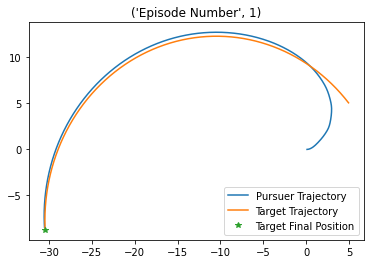

'\n*************************************\nModel Cheker for maneuvering evader\n*************************************\n'

In [15]:
'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''
dt = 0.1

ve = 0.9

#angle between initial velocity and reference
te = 3*np.pi/4

#Control Variable for evader
ue = 0.1

#Minimum Turning radius of evader
rhoe = 2

def transitionme(pursuer_state, state, u, fake_state, theta_velocity_e, theta_velocity_p): 

    old_phi = phi(state)

    #Change in x and y position of Pursuer
    del_xp = state[2]*dt
    del_yp = state[3]*dt
    
    #Change in x and y position of Evader
    del_xe = fake_state[2]*dt
    del_ye = fake_state[3]*dt
    
    #Change in Angle between velocity and reference axis
    del_theta_velocity_p = (v/rho)*u*dt
    theta_velocity_p = theta_velocity_p + del_theta_velocity_p
    
    #Change in Angle between evader velocity and reference axis
    del_theta_velocity_e = (ve/rhoe)*ue*dt
    theta_velocity_e = theta_velocity_e + del_theta_velocity_e
    
    #New x and y position of Pursuer
    state[0] = state[0] + del_xp
    state[1] = state[1] + del_yp
    
    #New x and y position of Evader
    state[4] = state[4] + del_xe
    state[5] = state[5] + del_ye
    
    #New x and y velocity of Pursuer
    state[2] = 1.0*np.cos(theta_velocity_p)
    state[3] = 1.0*np.sin(theta_velocity_p)
    
    v_e = [0,0]
    #New velocity of evader
    v_e[0] = ve*np.cos(theta_velocity_e)
    v_e[1] = ve*np.sin(theta_velocity_e)
    
    fake_state[2] = v_e[0]
    fake_state[3] = v_e[1]
    
    new_phi = phi(state)

    p_state = [0,0,0]
    
    #New phi and phi(dot)
    p_state[1] = phi(state)/np.pi
    #p_state[1] = (del_theta_velocity_p/dt)/(2*np.pi)
    p_state[0] = L(state)/30.0
    p_state[2] = (new_phi-old_phi)/dt
    
    return p_state, state, fake_state, theta_velocity_e, theta_velocity_p

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() #+ noise

    return [sampled_actions]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(1):

    sys_state = [0.0,0.0,1.0,0.0,5.0,5.0]
    prev_state = np.array([L(sys_state)/30.0, phi(sys_state)/np.pi,0])#, abs(alph(sys_state))/(2*np.pi)])
    
    velocity_evader = [ve*np.cos(te), ve*np.sin(te)]
    
    fake_state = [0.0, 0.0, velocity_evader[0], velocity_evader[1], 0.0, 0.0]
    
    theta_velocity_e = thetap(fake_state)
    theta_velocity_p = thetap(sys_state)
    
    
    episodic_reward = 0
    
    xc = []
    yc = []
    
    xce = []
    yce = []

    
    #while True:
    for i in range(1000):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)    
        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        new_state, sys_state, fake_state, theta_velocity_e, theta_velocity_p = transitionme(prev_state, sys_state, float(action[0]), fake_state, theta_velocity_e, theta_velocity_p)
        rew = reward(new_state)
        episodic_reward += rew
                
        if L(sys_state) <= 0.2:
            print ('****TARGET CAPTURED****')
            print('Captured after', i+1, 'steps')
            break
                
        prev_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[4])
        yce.append(sys_state[5])
        
    xc1 = [sys_state[4]]
    yc1 = [sys_state[5]]

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xc,yc, label = 'Pursuer Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()

'''
*************************************
Model Cheker for maneuvering evader
*************************************
'''